In [1]:
from pathlib import Path

In [2]:
import pandas as pd

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
import tarfile

In [5]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split

In [73]:
from sklearn.compose import TransformedTargetRegressor

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

In [10]:
import urllib.request

In [11]:
from sklearn.preprocessing import OrdinalEncoder

In [12]:
from pandas.plotting import scatter_matrix

In [13]:
from sklearn.preprocessing import OneHotEncoder

In [14]:
from sklearn.impute import SimpleImputer

In [15]:
def load_housing_data():
    tarball_path=Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True,exist_ok=True)
        url="https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url,tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [16]:
housing=load_housing_data()

In [17]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [18]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [19]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [20]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


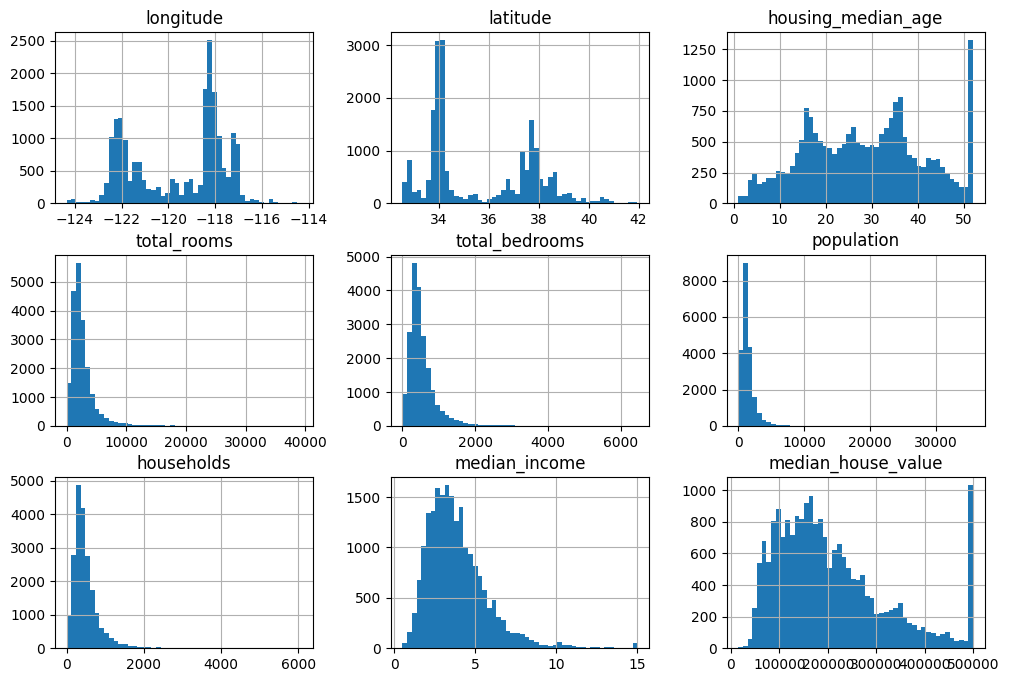

In [21]:
housing.hist(bins=50,figsize=(12,8))
plt.show()

In [22]:
def shuffle_and_split_data(data,test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [23]:
train_set,test_set=shuffle_and_split_data(housing,0.2)

In [24]:
len(train_set)

16512

In [25]:
from zlib import crc32

In [26]:
def is_id_in_test_set(identifier,test_ratio):
    return crc32(np.int64(identifier))<test_ratio*2**32

In [27]:
def split_data_with_id_hash(data,test_ratio,id_column):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_:is_id_in_test_set(id_,test_ratio))
    return data.loc[~in_test_set],data.loc[in_test_set]


In [28]:
housing_with_id=housing.reset_index()

In [29]:
train_set,test_set=split_data_with_id_hash(housing_with_id,0.2,"index")

In [30]:
housing_with_id["id"]=housing["longitude"]*1000+housing["latitude"]
train_set,test_set=split_data_with_id_hash(housing_with_id,0.2,"id")

In [31]:
train_set,test_set=train_test_split(housing,test_size=0.2,random_state=42)

In [32]:
housing["income_cat"]=pd.cut(housing["median_income"],bins=[0,1.5,3.0,4.5,6,np.inf],labels=[1,2,3,4,5])

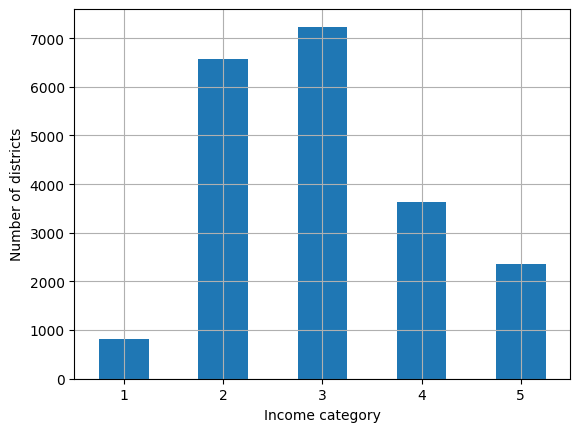

In [33]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [34]:
splitter=StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
strat_splits=[]
for train_index, test_index in splitter.split(housing,housing["income_cat"]):
    strat_train_set_n=housing.iloc[train_index]
    strat_test_set_n=housing.iloc[test_index]
    strat_splits.append([strat_train_set_n,strat_test_set_n])

In [35]:
strat_train_set,strat_test_set=strat_splits[0]

In [36]:
strat_train_set,strat_test_set=train_test_split(housing,test_size=0.2,stratify=housing["income_cat"],random_state=42)

In [37]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [38]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

In [39]:
housing=strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

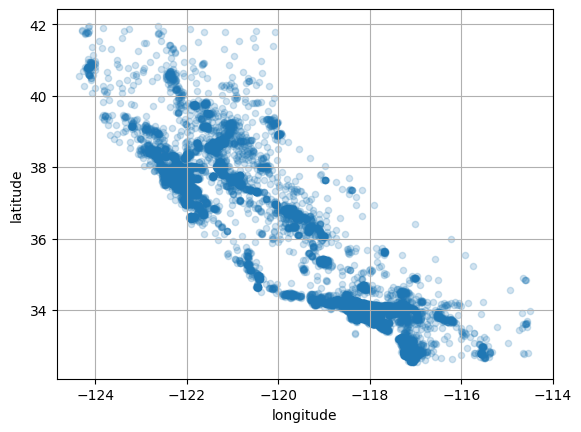

In [40]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True,alpha=0.2)

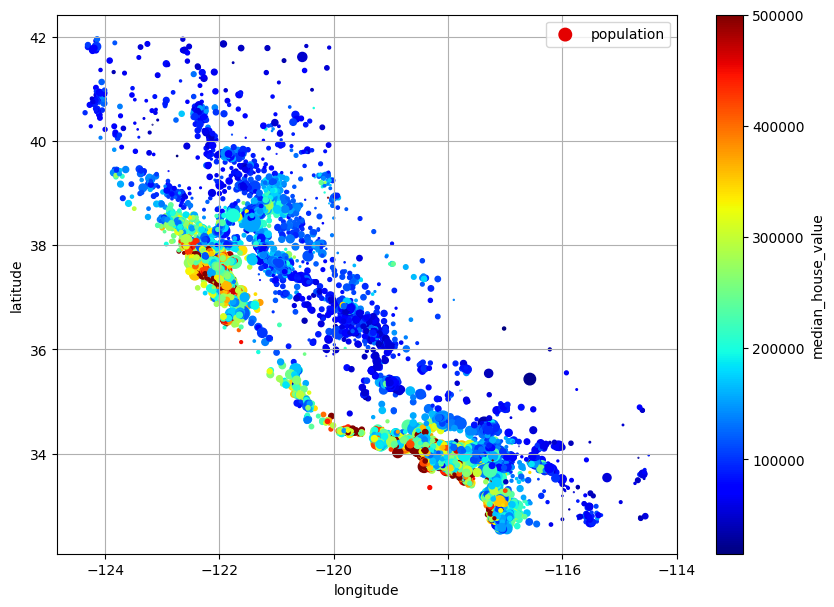

In [41]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True,s=housing["population"]/100,label="population",c="median_house_value",cmap="jet",colorbar=True,legend=True,sharex=False,figsize=(10,7))
plt.show()

In [42]:
corr_matrix=housing.corr(numeric_only=True)

In [43]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

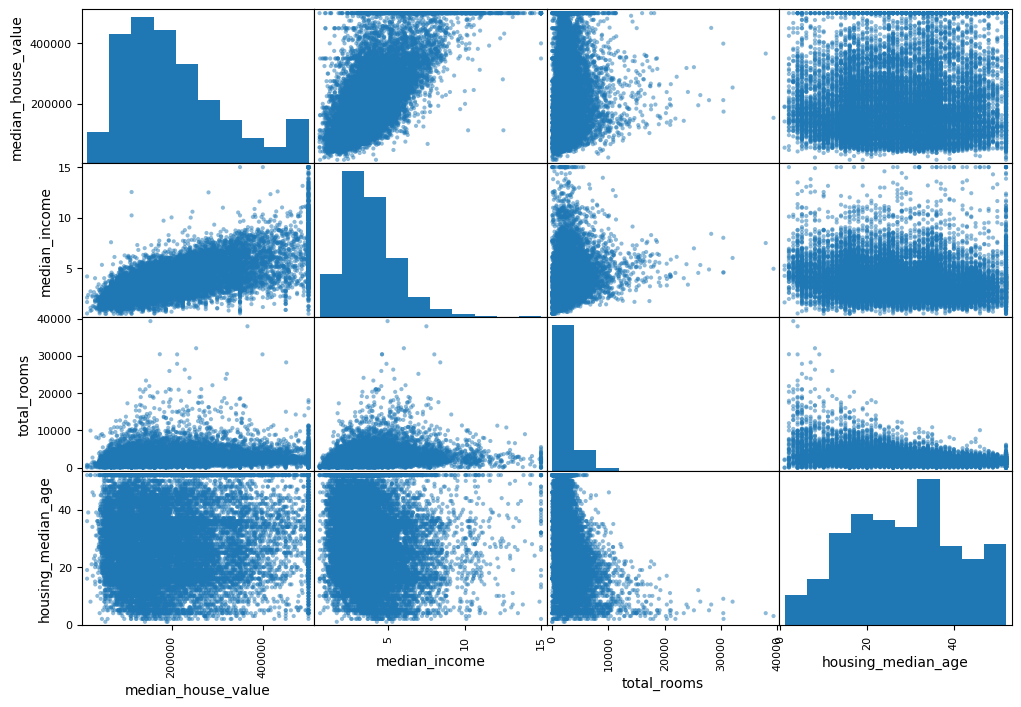

In [44]:
attributes=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

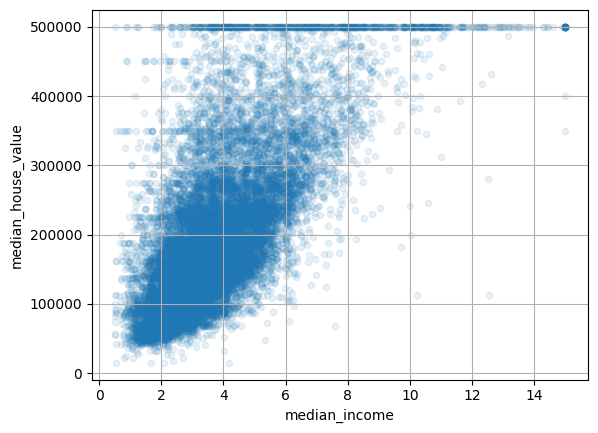

In [45]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1,grid=True)

In [46]:
housing["rooms_per_house"]=housing["total_rooms"]/housing["households"]
housing["bedroom_ratio"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"]=housing["population"]/housing["households"]

In [47]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

In [48]:
median=housing["total_bedrooms"].median()
housing["total_bedrooms"]=housing["total_bedrooms"].fillna(median)

In [49]:
imputer=SimpleImputer(strategy="median")

In [50]:
housing_num=housing.select_dtypes(include=[np.number])

In [51]:
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [52]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [53]:
X=imputer.transform(housing_num)

In [54]:
housing_tr=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

In [55]:
housing_cat=housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [56]:
ordinal_encoder=OrdinalEncoder()
housing_cat_encoded=ordinal_encoder.fit_transform(housing_cat)

In [57]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [58]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [59]:
cat_encoder=OneHotEncoder()
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)

In [60]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [61]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [62]:
cat_encoder.handle_unknown="ignore"

In [63]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [64]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [65]:
std_scaler=StandardScaler()
housing_num_std_scaled=std_scaler.fit_transform(housing_num)

In [68]:
target_scaler=StandardScaler()

In [ ]:
scaled_labels=target_scaler.fit_transform(housing_labels.to_frame())

In [72]:
model=LinearRegression()
model.fit(housing[["median_income"]],scaled_labels)
some_new_data=housing[["median_income"]].iloc[:5]
scaled_predictions=model.predict(some_new_data)
predictions=target_scaler.inverse_transform(scaled_predictions)

In [74]:
model=TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(housing[["median_income"]],housing_labels)
predictions=model.predict(some_new_data)